In [1]:
#Capstone Project: New Coffeeshop in Denver
#This project will load coffeeshops, and recommended coffeeshops, in Denver from Foursquare
#Denver is too large to get all coffeeshops in one call (max results is 50).
#Denver will be defined as a square, from 39.68 to 39.78 northern latitude, and -104.94 to -105.05 western longitude.
#Foursquare calls will loop over these coordinates, and results will be aggregated and duplicates removed
#Then, results will be plotted on a map to find areas with (1) few cafes, (2) few recommended cafes.
#An attempt will be made to use ML to draw a boundary between cafe-rich and cafe-poor areas.

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
#from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML
from IPython.display import set_matplotlib_formats
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 
set_matplotlib_formats('svg')
from matplotlib import rcParams


from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

!pip install folium==0.5.0
import folium

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 81kB 8.1MB/s eta 0:00:011
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
Folium installed
Libraries imported.


In [2]:
#Get data for coffeeshops within Denver
#Example: https://api.foursquare.com/v2/venues/search?client_id=ClientID&client_secret=ClientSecret&ll=LATITUDE,LONGITUDE&v=Version&query=COFFEE&radius=1500&limit=LIMIT
#Constants
CLIENT_ID='GAGJAXJQSQ0U2DZHK23VHSP5ZG3GJ3SVR1NRYRVJXO0HLDKM'
CLIENT_SECRET='CO0Y405NPGK15TOAYBWUHOVKODHDQ5RSBYVBS5WKYAI1HC1U'
VERSION='20180604'
#Variables
search_query='COFFEE'
radius=1500
LIMIT=1000

#Loop over city coordinates in ~1mile steps to get all coffeeshops.
res=[]
for i in np.linspace(39.68,39.78,11):
    for j in np.linspace(-105.05,-104.94,12):
        latitude=i
        longitude=j
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        # assign response to res2
        res2=[]
        res2 = results['response']['venues']
        #append res2 with data from current iteration to res, which will end up containing all data
        res=res+res2
len(res) #check length of dataset (list format for ease of data concatenation).

1902

In [3]:
#Take relevant columns into dataframe, remove duplicates
cafe = json_normalize(res)[['id','name','location.lat','location.lng']]
print (cafe.shape)
cafe.drop_duplicates(inplace=True)
print (cafe.shape)
cafe.head() #It appears our method has high redundancy, it was crucial to drop duplicates

(1902, 4)
(224, 4)


,id,name,location.lat,location.lng
0,4f32384819836c91c7c1f3b5,Coffee Bean and Tea Leaf,39.668116,-105.011429
1,4c44d015dcd61b8d0fdf7b56,Elevation Coffee Traders,39.667340,-105.010650
3,4f44094c19836ed00191e9d4,Stella's Gourmet Coffee and Such,39.681791,-104.993835
5,4f323d1d19836c91c7c3da79,Rojas Mexican Grill and Coffee,39.690228,-104.991798
6,4f977ce1e4b0da3ed6741a9e,Corvus Coffee Roasters,39.684848,-104.987261


In [4]:
#Get data for TRENDING coffeeshops in Denver
#Use as approximation for "good" coffeeshops since calling ratings is a premium call and we have more than 500 coffeeshops.

#Constants
CLIENT_ID='GAGJAXJQSQ0U2DZHK23VHSP5ZG3GJ3SVR1NRYRVJXO0HLDKM'
CLIENT_SECRET='CO0Y405NPGK15TOAYBWUHOVKODHDQ5RSBYVBS5WKYAI1HC1U'
VERSION='20180604'
#Variables
search_query='COFFEE'
radius=1500
LIMIT=1000

#Loop over city coordinates in ~1mile steps to get all trending coffeeshops.
res3=[]
for i in np.linspace(39.68,39.78,11):
    for j in np.linspace(-105.05,-104.94,12):
        latitude=i
        longitude=j
        url2 = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
        results2 = requests.get(url2).json()
        # assign response to res2
        res4=[]
        res4 = results2['response']['venues']
        #append res2 with data from current iteration to res, which will end up containing all data
        res3=res3+res4
print (len(res3)) #check length of dataset (list format for ease of data concatenation).

#Take relevant columns into dataframe
cafe_rec = json_normalize(res3)[['id','name','location.lat','location.lng']]
cafe_rec.drop_duplicates(inplace=True)
cafe_rec #only 1 of 224 are "trending"

8


,id,name,location.lat,location.lng
0,4abce1f0f964a5208c8720e3,Starbucks,39.71954,-104.9532


In [5]:
#Get data for all businesses within Denver
#Constants
CLIENT_ID='GAGJAXJQSQ0U2DZHK23VHSP5ZG3GJ3SVR1NRYRVJXO0HLDKM'
CLIENT_SECRET='CO0Y405NPGK15TOAYBWUHOVKODHDQ5RSBYVBS5WKYAI1HC1U'
VERSION='20180604'
#Variables
radius=1500
LIMIT=1000

#Loop over city coordinates in ~1mile steps to get all businesses.
res5=[]
for i in np.linspace(39.68,39.78,11):
    for j in np.linspace(-105.05,-104.94,12):
        latitude=i
        longitude=j
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
        results3 = requests.get(url).json()
        # assign response to res2
        res6=[]
        res6 = results3['response']['venues']
        #append res2 with data from current iteration to res, which will end up containing all data
        res5=res5+res6
print (len(res5)) #check length of dataset (list format for ease of data concatenation).

#Take relevant columns into dataframe
venues = json_normalize(res5)[['id','name','location.lat','location.lng']]
venues.drop_duplicates(inplace=True)
venues.shape

14114


(11470, 4)

In [7]:
#We've now loaded all the data we need from Foursquare. 
cafe #list of cafes
cafe_rec #list of trending cafes
venues #total list of venes. Rationale is that we want to open cafe in area with FEW cafes but MANY other businesses. If there's no cafes but nothing else either there won't be any customers.

In [8]:
#map of Denver
mapD = folium.Map(location=[39.73, -105], zoom_start=12)
  
# add cafe markers to map, blue
for lat, lng, name in zip(cafe['location.lat'], cafe['location.lng'], cafe['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapD)  

#add recommended cafes to map purple
for lat, lng, name in zip(cafe_rec['location.lat'], cafe_rec['location.lng'], cafe_rec['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(mapD)
    
#add rectangle of studied area. Some cafes are outside because rectangle defines points that were rastered with 1500m radius.
folium.features.RectangleMarker(bounds=[39.78,-105.05,39.68,-104.94], color='black', fill_opacity=0).add_to(mapD)

mapD

In [19]:
#We can see that the one trending cafe doesn't impact our findings. However, there is a large area in the southwest of Denver that doesn't have any cafes at all.
#Let's check whether this is because there aren't any businesses.

In [9]:
#Convert individual cafes to a density function. Loop through same points used to source data, count number of cafes and venues closest to that point, and write them to table.
#This could not be done during import because duplicates had to be removed first.
density=pd.DataFrame(columns=['lat','lng','cafenum','venuenum']) #empty df for results
line=0 #line increment variable
for i in np.linspace(39.68,39.78,11):
    for j in np.linspace(-105.05,-104.94,12):
        A=i-0.005
        B=i+0.005
        C=j-0.005
        D=j+0.005
        cafe_sub=cafe[cafe['location.lat'] > A][cafe['location.lat'] < B][cafe['location.lng'] > C][cafe['location.lng'] < D]
        cafnum=cafe_sub.shape[0]
        venue_sub=venues[venues['location.lat'] > A][venues['location.lat'] < B][venues['location.lng'] > C][venues['location.lng'] < D]
        vennum=venue_sub.shape[0]
        density.loc[line]=[i,j,cafnum,vennum]
        line=line+1 #counting variable, so prior line of code fills in one line after the other
density.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,lat,lng,cafenum,venuenum
0,39.68,-105.05,0.0,67.0
1,39.68,-105.04,0.0,14.0
2,39.68,-105.03,0.0,61.0
3,39.68,-105.02,0.0,79.0
4,39.68,-105.01,0.0,72.0


In [10]:
density.describe() ##average 0.01° x 0.01 ° grid square (roughly 1km2). Cafes are much more unevenly distributed than venues (std>mean for cafes), so there should be area with venues but few cafes

,lat,lng,cafenum,venuenum
count,132.000000,132.000000,132.000000,132.000000
mean,39.730000,-104.995000,1.560606,84.287879
std,0.031743,0.034652,2.676609,34.343912
min,39.680000,-105.050000,0.000000,13.000000
25%,39.700000,-105.022500,0.000000,61.000000
50%,39.730000,-104.995000,1.000000,83.500000
75%,39.760000,-104.967500,2.000000,112.000000
max,39.780000,-104.940000,18.000000,191.000000


In [11]:
#map of Denver, densities
mapD3 = folium.Map(location=[39.73, -105], zoom_start=12)
folium.features.RectangleMarker(bounds=[39.78,-105.05,39.68,-104.94], color='black', fill_opacity=0).add_to(mapD3)  
# add cafe markers to map, blue
for lat, lng, cnum, vnum in zip(density['lat'], density['lng'], density['cafenum'], density['venuenum']):
    folium.CircleMarker([lat, lng],radius=vnum/10,color='red',parse_html=False).add_to(mapD3) 
    folium.CircleMarker([lat, lng],radius=cnum,color='blue',fill=True,fill_color='blue',fill_opacity=0.7,parse_html=False).add_to(mapD3)
    
mapD3
##Map has radii correlating with number of venues and cafes at each grid point.
##Shows that there are venues, i.e. businesses, everywhere, but many areas, especially south-west, with few cafes. New ones should be sited there.

In [135]:
#Let's use some machine learning. We will go back to the original dataset of cafes and cluster them, then plot the cluster sizes to have different view of "empty" areas.



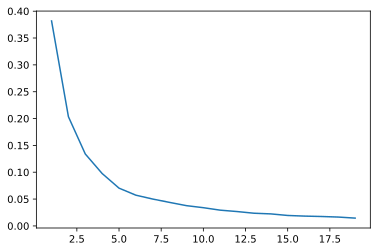

In [12]:
#Run K-means clustering with 1-10 centers. Write number of centers to ncl_x, and quality of fit to ncl_y, then plot.
#Use attribute .inertia_ for quality of fit: https://stackoverflow.com/questions/43784903/scikit-k-means-clustering-performance-measure
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
Xcl=np.asarray(cafe[['location.lat','location.lng']]) #convert to x-y array for clustering
ncl_x=np.zeros(19)
ncl_y=np.zeros(19)
for ncl in range(1,20):
    kmfunc=KMeans(init="k-means++", n_clusters=ncl, n_init=12).fit(Xcl)
    ncl_x[ncl-1]=ncl
    ncl_y[ncl-1]=kmfunc.inertia_
plt.plot(ncl_x,ncl_y)



In [13]:
#Optimum is 5. Execute, write cluster centers to array, add clusterID to dataframe
kmfunc2=KMeans(init="k-means++", n_clusters=5, n_init=12).fit(Xcl)
centers=kmfunc2.cluster_centers_
cafe['ClusterID']=kmfunc2.labels_
cafe.head()

,id,name,location.lat,location.lng,ClusterID
0,4f32384819836c91c7c1f3b5,Coffee Bean and Tea Leaf,39.668116,-105.011429,3
1,4c44d015dcd61b8d0fdf7b56,Elevation Coffee Traders,39.667340,-105.010650,3
3,4f44094c19836ed00191e9d4,Stella's Gourmet Coffee and Such,39.681791,-104.993835,3
5,4f323d1d19836c91c7c3da79,Rojas Mexican Grill and Coffee,39.690228,-104.991798,3
6,4f977ce1e4b0da3ed6741a9e,Corvus Coffee Roasters,39.684848,-104.987261,3


In [14]:
cafe.groupby('ClusterID').count() #Clusters have different sizes



,id,name,location.lat,location.lng
ClusterID,,,,
0,25,25,25,25
1,39,39,39,39
2,28,28,28,28
3,33,33,33,33
4,99,99,99,99


In [16]:
#New map of Denver. Cafes are color coded with their cluster.
mapD2 = folium.Map(location=[39.73, -105], zoom_start=12)
ColorTable=['black','red','blue','green','orange'] 
# add cafe markers to map, blue
for lat, lng, name, CLID in zip(cafe['location.lat'], cafe['location.lng'], cafe['name'], cafe['ClusterID']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=ColorTable[CLID],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapD2)
    
#add giant circle for each cluster
iii=0 #Color index
for lat2, lng2 in zip(centers[:,0], centers[:,1]):
    folium.Circle(location=(lat2,lng2),color=ColorTable[iii],radius=2000,fill=False,parse_html=False).add_to(mapD2)
    iii=iii+1

#add recommended cafes to map purple
for lat, lng, name in zip(cafe_rec['location.lat'], cafe_rec['location.lng'], cafe_rec['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(mapD2)
    
#add rectangle of studied area. Some cafes are outside because rectangle defines points that were rastered with 1500m radius.
folium.features.RectangleMarker(bounds=[39.78,-105.05,39.68,-104.94], color='black', fill_opacity=0).add_to(mapD2)

mapD2